# Simple BinConv Training Example

This notebook demonstrates BinConv training on a single time series with small Gaussian noise, where the forecast horizon equals the context length for comprehensive forecasting.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from binconvfm.models.binconv import LightningBinConv
from pytorch_lightning import Trainer

print("📦 Simple BinConv training setup ready!")

📦 Simple BinConv training setup ready!


## Generate Simple Time Series with Small Gaussian Noise

📈 Generated time series:
   Length: 1000
   Mean: 5.996
   Std: 2.889
   Context length: 64
   Prediction length: 64


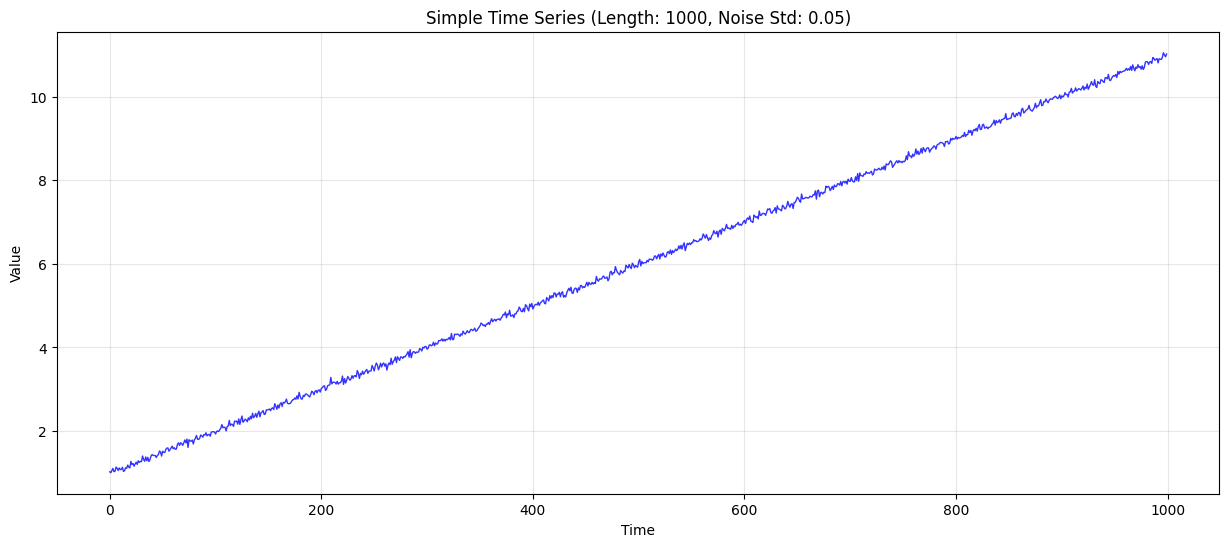

In [2]:
# Configuration
context_length = 64
prediction_length = context_length  # Forecast horizon = context length
total_length = 1000  # Total time series length
noise_std = 0.05  # Small Gaussian noise

def generate_simple_time_series(length, noise_std):
    """Generate a single time series with linear trend and small Gaussian noise."""
    t = np.arange(length)
    
    # Simple linear trend with gentle slope
    trend = 0.01 * t + 1.0
    
    # Add small Gaussian noise
    noise = np.random.normal(0, noise_std, length)
    
    # Combine trend and noise
    series = trend + noise
    
    return series

# Generate the single time series
np.random.seed(42)  # For reproducibility
time_series = generate_simple_time_series(total_length, noise_std)

print(f"📈 Generated time series:")
print(f"   Length: {len(time_series)}")
print(f"   Mean: {time_series.mean():.3f}")
print(f"   Std: {time_series.std():.3f}")
print(f"   Context length: {context_length}")
print(f"   Prediction length: {prediction_length}")

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(time_series, 'b-', alpha=0.8, linewidth=1)
plt.title(f'Simple Time Series (Length: {total_length}, Noise Std: {noise_std})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

## Create Dataset from Single Time Series

In [3]:
class SimpleTimeSeriesDataset(Dataset):
    """
    Dataset that creates sliding windows from a single time series.
    
    Each sample consists of:
    - Input: context_length time steps
    - Target: next prediction_length time steps
    """
    
    def __init__(self, time_series, context_length, prediction_length):
        self.time_series = torch.FloatTensor(time_series)
        self.context_length = context_length
        self.prediction_length = prediction_length
        
        # Calculate number of valid windows
        self.num_samples = len(time_series) - context_length - prediction_length + 1
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Input: context_length time steps
        input_seq = self.time_series[idx:idx + self.context_length].unsqueeze(-1)
        
        # Target: next prediction_length time steps  
        target_seq = self.time_series[idx + self.context_length:idx + self.context_length + self.prediction_length].unsqueeze(-1)
        
        return input_seq, target_seq

# Create datasets
train_split = int(0.8 * total_length)  # Use 80% for training
train_series = time_series[:train_split]
val_series = time_series[train_split:]

train_dataset = SimpleTimeSeriesDataset(train_series, context_length, prediction_length)
val_dataset = SimpleTimeSeriesDataset(val_series, context_length, prediction_length)

print(f"📊 Dataset Statistics:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

# Check sample shapes
sample_input, sample_target = train_dataset[0]
print(f"   Sample input shape: {sample_input.shape}")
print(f"   Sample target shape: {sample_target.shape}")

# Show a few samples
print(f"\\n🔍 Sample Data (first 3 samples):")
for i in range(3):
    input_seq, target_seq = train_dataset[i]
    print(f"   Sample {i}: input[0]={input_seq[0].item():.3f}, target[0]={target_seq[0].item():.3f}")

📊 Dataset Statistics:
   Training samples: 673
   Validation samples: 73
   Sample input shape: torch.Size([64, 1])
   Sample target shape: torch.Size([64, 1])
\n🔍 Sample Data (first 3 samples):
   Sample 0: input[0]=1.025, target[0]=1.681
   Sample 1: input[0]=1.003, target[0]=1.718
   Sample 2: input[0]=1.052, target[0]=1.656


## Initialize Simple BinConv Model

In [4]:
# Simple model configuration
num_bins = 64  # Smaller number of bins for simplicity
min_bin_value = -2.0
max_bin_value = 2.0
learning_rate = 1e-3

# Initialize BinConv model
model = LightningBinConv(
    context_length=context_length,
    is_prob_forecast=True,
    num_bins=num_bins,
    min_bin_value=min_bin_value,
    max_bin_value=max_bin_value,
    num_filters_2d=8,  # Smaller for simplicity
    num_filters_1d=8,
    num_blocks=1,  # Single block for simplicity
    kernel_size_ffn=7,  # Smaller kernel
    prediction_length=prediction_length,
    target_dim=1,
    dropout=0.1,
    scaler_type='standard',  # Use standard scaling
    lr=learning_rate
)

total_params = sum(p.numel() for p in model.parameters())
print(f"🧠 Simple BinConv Model:")
print(f"   Parameters: {total_params:,}")
print(f"   Context length: {context_length}")
print(f"   Prediction length: {prediction_length}")
print(f"   Number of bins: {num_bins}")
print(f"   Learning rate: {learning_rate}")

🧠 Simple BinConv Model:
   Parameters: 2,315
   Context length: 64
   Prediction length: 64
   Number of bins: 64
   Learning rate: 0.001


In [5]:
# Simple training setup
batch_size = 16
num_epochs = 10

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"🚂 Training Setup:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Epochs: {num_epochs}")

# Simple trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator='cpu',
    enable_progress_bar=True,
    log_every_n_steps=10,
    enable_checkpointing=False,
    logger=False
)

# Train the model
print(f"\\n🏃 Starting simple training...")
trainer.fit(model, train_loader, val_loader)
print(f"✅ Training completed!")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andreichernov/Documents/Personal/research/AIFM/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | dropout | Dropout    | 0      | train
1 | act     | ModuleList | 17     | train
2 | layers  | ModuleList | 2.3 K  | train
-----------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


🚂 Training Setup:
   Batch size: 16
   Training batches: 43
   Validation batches: 5
   Epochs: 10
\n🏃 Starting simple training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andreichernov/Documents/Personal/research/AIFM/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


ValueError: Target size (torch.Size([16, 64, 1])) must be the same as input size (torch.Size([16, 1]))

## Test Long-Horizon Forecasting

In [ ]:
# Test the model on a portion of the time series
test_start = 500
test_context = time_series[test_start:test_start + context_length]
test_true = time_series[test_start + context_length:test_start + context_length + prediction_length]

# Prepare input for model
test_input = torch.FloatTensor(test_context).unsqueeze(0).unsqueeze(-1)  # (1, context_length, 1)

print(f"🧪 Testing Long-Horizon Forecasting:")
print(f"   Context length: {len(test_context)}")
print(f"   Prediction length: {len(test_true)}")
print(f"   Input shape: {test_input.shape}")

# Make prediction
model.eval()
with torch.no_grad():
    # Use forecast method for long-horizon prediction
    forecasts = model.forecast(test_input, num_samples=1)
    print(f"   Forecast shape: {forecasts.shape}")

# Visualize results
plt.figure(figsize=(16, 8))

# Plot context
context_x = np.arange(len(test_context))
plt.plot(context_x, test_context, 'b-', label='Context (Input)', linewidth=2)

# Plot true future
future_x = np.arange(len(test_context), len(test_context) + len(test_true))
plt.plot(future_x, test_true, 'g-', label='True Future', linewidth=2)

# Plot predictions
try:
    if forecasts.dim() >= 4:
        # Extract predictions from forecast tensor
        pred_values = []
        for i in range(min(prediction_length, forecasts.shape[2])):
            if forecasts.shape[-1] > 1:  # If quantized output
                # Convert from binary back to continuous (simplified)
                pred_val = forecasts[0, 0, i, 0].item()
            else:
                pred_val = forecasts[0, 0, i].item()
            pred_values.append(pred_val)
        
        pred_x = np.arange(len(test_context), len(test_context) + len(pred_values))
        plt.plot(pred_x, pred_values, 'r--', label='BinConv Predictions', linewidth=2, marker='o')
        
        # Calculate simple error metric
        if len(pred_values) == len(test_true):
            mae = np.mean(np.abs(np.array(pred_values) - test_true))
            print(f"   Mean Absolute Error: {mae:.4f}")
    
except Exception as e:
    print(f"⚠️  Could not extract predictions: {e}")

plt.axvline(x=len(test_context), color='red', linestyle=':', alpha=0.5, label='Prediction Start')
plt.title(f'BinConv Long-Horizon Forecasting (Context={context_length}, Forecast={prediction_length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\\n🎯 Simple BinConv Example Complete!")
print(f"   ✅ Single time series with small Gaussian noise")
print(f"   ✅ Forecast horizon = Context length ({prediction_length} steps)")
print(f"   ✅ Simple model architecture for easy understanding")